# Simple regression example


In this example, we consider the standard Boston housing dataset from Scikit-learn and implement some regression models.


In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import mean_squared_error
from river import stream
from sail.transformers.river.preprocessing import StandardScaler
from sail.models.river.linear_model import LinearRegression
import time
from sail.models.ensemble.distAggregateRegressor import DistAggregateRegressor
import numpy as np
from river import optim
import matplotlib.pyplot as plt 

In [2]:
print("Boston housing dataset prediction.")
boston = pd.read_csv(
    "http://lib.stat.cmu.edu/datasets/boston",
    sep="\\s+",
    skiprows=22,
    header=None,
)
boston_data, boston_target = (
    np.hstack([boston.values[::2, :], boston.values[1::2, :2]]),
    boston.values[1::2, 2],
)

df_X = pd.DataFrame(boston_data, columns=range(0, 13))
df_y = pd.Series(boston_target)

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)

stdScaler_many = StandardScaler()

model_many = LinearRegression(optimizer=optim.RMSProp())

dataset = stream.iter_pandas(X_train, y_train)

stdScaler_many.learn_many(X_train)
X_train = stdScaler_many.transform_many(X_train)

X_train.head()
print(type(X_train), type(y_train))

Boston housing dataset prediction.
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


In [3]:
optimizers = [optim.SGD(0.01), optim.RMSProp(), optim.AdaGrad()]

hedge = DistAggregateRegressor(estimators=[
        LinearRegression(optimizer=o, intercept_lr=.1)
        for o in optimizers],
        learning_rate=0.005
    )

for xi, yi in stream.iter_array(X_train.to_numpy(), y_train.to_numpy(), feature_names=list(X_train.columns)):
    xi = np.array([np.fromiter(xi.values(), dtype=float)])
    yi = np.array([yi])
    start = time.time()
    hedge.partial_fit(xi,yi) 
    # hedge.partial_fit(x, yi)

print("duration =", time.time() - start)

2023-09-26 13:23:25,770	INFO worker.py:1621 -- Started a local Ray instance.


duration = 0.004168987274169922


In [4]:
for i in range(2):    
    for xi, yi in stream.iter_array(X_train.to_numpy(), y_train.to_numpy(), feature_names=list(X_train.columns)):
        xi = np.array([np.fromiter(xi.values(), dtype=float)])
        yi = np.array([yi])
        start = time.time()
        hedge.partial_fit(xi,yi) 
        # hedge.partial_fit(x, yi)

print("duration =", time.time() - start)

duration = 0.006674051284790039


In [5]:
x = X_test
x = stdScaler_many.transform_many(x)
start = time.time()
ypred_hedge = hedge.predict(x)
print("duration =", time.time() - start)

mse = mean_squared_error(y_test, ypred_hedge)
print("MSE_hedge: ", mse)
print("RMSE_hedge: ", mse**(1/2.0))

duration = 0.0035262107849121094
MSE_hedge:  24.118947950037438
RMSE_hedge:  4.91110455498938


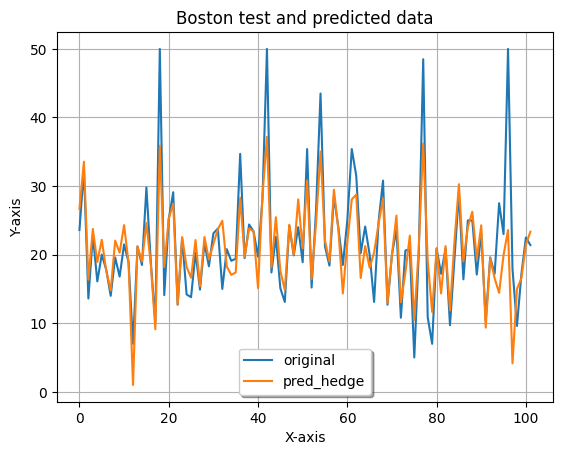

In [6]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, ypred_hedge, label="pred_hedge")
# plt.plot(x_ax, ypred_one, label="pred_one")
# plt.plot(x_ax, ypred_many, label="pred_many")
# plt.plot(x_ax, ypred_sk, label="pred_sk")
plt.title("Boston test and predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()